# Lane Detection and Classification using Cascaded CNNs - Inference Code

First of all, we are going to load the basic components, i.e. the required libraries (including pytorch) and our CNN models.

In [1]:
import torch
import torchvision
import numpy as np
import random
import math
import cv2
# Data loading and visualization imports
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib.pyplot import imshow, figure, subplots

# Model loading
from models.erfnet import Net as ERFNet
from models.lcnet import Net as LCNet

# utils
from functions import color_lanes, blend

# to cuda or not to cuda
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    

We can also define some constants. In this example, we are using 64x64 descriptors, a maximum of 5 classes for the instance segmentation network (0=background + 4 lanes) and 3 classes (continuous, dashed, double-dashed).

In [2]:
# Descriptor size definition
DESCRIPTOR_SIZE = 64

# Maximum number of lanes the network has been trained with + background
NUM_CLASSES_SEGMENTATION = 5

# Maxmimum number of classes for classification
NUM_CLASSES_CLASSIFICATION = 3

# Image size
HEIGHT = 360
WIDTH = 640

We also need to load the weights of the CNNs. We simply load it using pytorch methods.

In [3]:
# Creating CNNs and loading pretrained models
segmentation_network = ERFNet(NUM_CLASSES_SEGMENTATION)
classification_network = LCNet(NUM_CLASSES_CLASSIFICATION, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)

segmentation_network.load_state_dict(torch.load('pretrained/erfnet_tusimple.pth', map_location = map_location))
model_path = 'pretrained/classification_{}_{}class.pth'.format(DESCRIPTOR_SIZE, NUM_CLASSES_CLASSIFICATION)
classification_network.load_state_dict(torch.load(model_path, map_location = map_location))

segmentation_network = segmentation_network.eval()
classification_network = classification_network.eval()

if torch.cuda.is_available():
    segmentation_network = segmentation_network.cuda()
    classification_network = classification_network.cuda()

Now we load the data for the example. We load the image, visualize it, resize it and build a minibatch of size 1x3x360x640 that will be forwarded to the CNN.

In [4]:
img=cv2.imread('images/test.jpg')
img= Image.fromarray(img)


In [5]:
def read_image(img):
    im = img.resize((WIDTH, HEIGHT))
    im_tensor = ToTensor()(im)
    im_tensor = im_tensor.unsqueeze(0)
    return im,im_tensor


Now: we forward the image to the instance segmentation network and extract an instance segmentation map. In this way, we will have a 360x640 image, where nonzero pixels represent different lane boundaries.

In [6]:
def seg_infer(im_tensor):
    # Inference on instance segmentation
    if torch.cuda.is_available():
        im_tensor = im_tensor.cuda()

    out_segmentation = segmentation_network(im_tensor)
    out_segmentation = out_segmentation.max(dim=1)[1]
    return out_segmentation

In order to evaluate the instance segmentation quality, we can visualize it. The `color_lanes` method is used to map each lane instance index `i` to a random color. It is defined in `functions.py`.

In [7]:
def viz(im,out_segmentation):
    # Converting to numpy for visualization
    out_segmentation_np = out_segmentation.cpu().numpy()[0]
    out_segmentation_viz = np.zeros((HEIGHT, WIDTH, 3))

    for i in range(1, NUM_CLASSES_SEGMENTATION):
        rand_c1 = random.randint(1, 255)
        rand_c2 = random.randint(1, 255)    
        rand_c3 = random.randint(1, 255)
        out_segmentation_viz = color_lanes(
            out_segmentation_viz, out_segmentation_np, 
            i, (rand_c1, rand_c2, rand_c3), HEIGHT, WIDTH)

    im_seg = blend(im, out_segmentation_viz)
    return im_seg

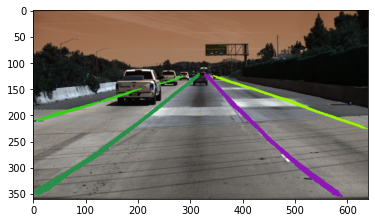

In [8]:
im,tensor=read_image(img)
im_seg=seg_infer(tensor)
im_seg=viz(im,im_seg)
imshow(np.asarray(im_seg))


In [9]:
import cv2
import numpy as np
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videos/project_video.mp4')

#get size to be saved
size = (WIDTH,HEIGHT)
#fps of video
fps = cap.get(cv2.CAP_PROP_FPS)
#video saved format
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('videos/output_video.avi', fourcc, fps, size)

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    img= Image.fromarray(frame)
    im,tensor=read_image(img)
    im_seg=seg_infer(tensor)
    im_seg=viz(im,im_seg)
    # Display the resulting frame
    cv2.imshow('Frame',np.array(im_seg))
    out.write(np.array(im_seg).astype('uint8'))
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()